In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# Colonne standard dei CSV
columns_standard = [
    "istat_comune", "regione", "provincia", "comune", "popolazione", "dato_riferito_a",
    "frazione_umida_t", "verde_t", "carta_e_cartone_t", "vetro_t", "legno_t", "metallo_t",
    "plastica_t", "raee_t", "tessili_t", "selettiva_t", "rifiuti_c_d_t", "pulizia_stradale_t",
    "ingombranti_misti_t", "altro_t", "totale_rd_t", "ingombranti_smaltimento_t",
    "indifferenziato_t", "totale_ru_t", "percentuale_rd_perc"
]

def load_ispra_clean(path, year):
    
    df = pd.read_csv(path, sep=";", encoding="latin-1", header=None, skiprows=3)
    df = df.iloc[:, :len(columns_standard)]
    df.columns = columns_standard

    # Pulizia spazi/tab dalle colonne chiave
    for col in ["istat_comune", "regione", "provincia", "comune", "dato_riferito_a"]:
        df[col] = df[col].astype(str).str.strip()

    # Pulizia numerica
    numeric_cols = [col for col in columns_standard if col not in ["istat_comune", "regione", "provincia", "comune", "popolazione", "dato_riferito_a"]]
    for col in numeric_cols:
        df[col] = (
            df[col].astype(str)
            .str.replace(".", "", regex=False)
            .str.replace(",", ".", regex=False)
            .str.replace("%", "", regex=False)
            .str.strip()
        )
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Percentuale RD se mancante
    df["percentuale_rd_perc"] = np.where(
        df["percentuale_rd_perc"].isna(),
        df["totale_rd_t"] / df["totale_ru_t"] * 100,
        df["percentuale_rd_perc"]
    )

    df["anno"] = year
    return df

# File per anno
files = {
    2020: "Anno_2020_RUComunali.csv",
    2021: "Anno_2021_RUComunali.csv",
    2022: "Anno_2022_RUComunali.csv",
    2023: "Anno_2023_RUComunali.csv"
}

# 1. Carica i file
dfs = [load_ispra_clean(path, year) for year, path in files.items()]

# 2. Concatenazione
df_all = pd.concat(dfs, ignore_index=True)

# 3. Raggruppa per comune e anno (somma numerici, max/min per non numerici)
group_cols = ["istat_comune", "comune", "provincia", "regione", "anno"]
numeric_cols = [col for col in df_all.columns if col not in ["istat_comune", "comune", "provincia", "regione", "popolazione", "dato_riferito_a", "anno"]]

df_grouped = df_all.groupby(group_cols, as_index=False).agg(
    {**{col: "sum" for col in numeric_cols},
     "popolazione": "max",
     "dato_riferito_a": "first"}
)

# 4. Pivot per avere colonne separate per anno
df_pivot = df_grouped.pivot_table(
    index=["istat_comune", "comune", "provincia", "regione", "popolazione", "dato_riferito_a"],
    columns="anno",
    values=numeric_cols
)

# 5. Appiattisci MultiIndex colonne
df_pivot.columns = [f"{val}_{col}" for val, col in df_pivot.columns]
df_pivot = df_pivot.reset_index()

# Sostituisci NaN numerici con 0
numeric_cols = df_pivot.select_dtypes(include=[np.number]).columns
df_pivot[numeric_cols] = df_pivot[numeric_cols].fillna(0)

# Salva CSV finale pulito
df_pivot.to_csv("RU_Comunali_2020_2023_finale_aggregato_pulito.csv", index=False, sep=";", encoding="utf-8")



print(df_pivot.head())


  istat_comune   comune provincia   regione  popolazione dato_riferito_a  \
0     01001001   AGLIE'    Torino  Piemonte       2548.0          Comune   
1     01001001   AGLIE'    Torino  Piemonte       2549.0          Comune   
2     01001001   AGLIE'    Torino  Piemonte       2558.0          Comune   
3     01001001   AGLIE'    Torino  Piemonte       2603.0          Comune   
4     01001002  AIRASCA    Torino  Piemonte       3569.0          Comune   

   altro_t_2020  altro_t_2021  altro_t_2022  altro_t_2023  ...  \
0         3.157         0.000         0.000         0.000  ...   
1         0.000         1.868         0.000         0.000  ...   
2         0.000         0.000         2.084         0.000  ...   
3         0.000         0.000         0.000         2.166  ...   
4         0.025         0.000         0.000         0.000  ...   

   totale_ru_t_2022  totale_ru_t_2023  verde_t_2020  verde_t_2021  \
0             0.000             0.000       396.303          0.00   
1       

<h1> Calcolo rifiuti pro capite (kg/abitante) per anno </h1>

In [3]:


# Carica file pulito aggregato
df = pd.read_csv("RU_Comunali_2020_2023_finale_aggregato_pulito.csv", sep=";")

anni = [2020, 2021, 2022, 2023]

# Calcolo RU pro capite in kg
for year in anni:
    ru_col = f"totale_ru_t_{year}"
    pc_col = f"totale_ru_pc_{year}"
    df[pc_col] = (df[ru_col] * 1000) / df["popolazione"]

# Controllo prime righe
df[[f"totale_ru_t_2020", f"totale_ru_pc_2020", f"totale_ru_t_2021", f"totale_ru_pc_2021"]].head()


,totale_ru_t_2020,totale_ru_pc_2020,totale_ru_t_2021,totale_ru_pc_2021
0,1563.893,613.772763,0.000,0.000000
1,0.000,0.000000,1409.963,553.143586
2,0.000,0.000000,0.000,0.000000
3,0.000,0.000000,0.000,0.000000
4,2032.627,569.522836,0.000,0.000000


In [4]:
# print(df.columns.tolist())


<h1> Percentuale raccolta per regione <h1>

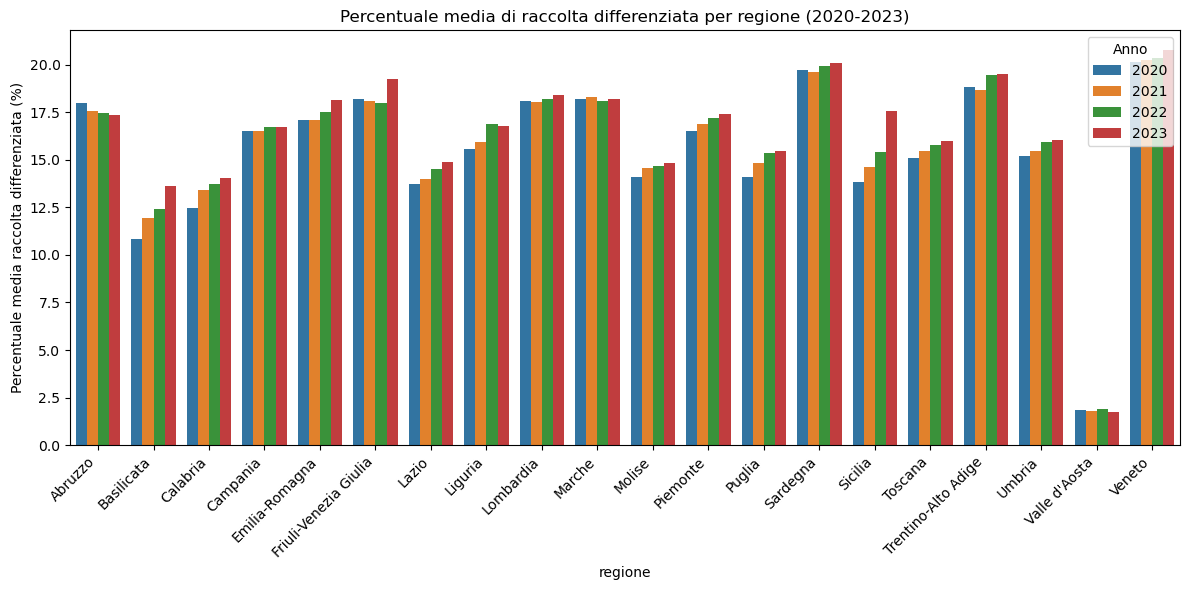

In [4]:


df = pd.read_csv(
    "RU_Comunali_2020_2023_finale_aggregato_pulito.csv",
    sep=";",       # separatore corretto
    encoding="utf-8",
    on_bad_lines="skip"
)

# 2️⃣ Pulizia dei nomi delle colonne (spazi/tab)
df.columns = df.columns.str.strip()

# 3️⃣ Colonne della percentuale di RD
rd_cols = ['percentuale_rd_perc_2020', 'percentuale_rd_perc_2021', 
           'percentuale_rd_perc_2022', 'percentuale_rd_perc_2023']

# 4️⃣ Media per regione
df_region = df.groupby("regione")[rd_cols].mean().reset_index()

# 5️⃣ Trasforma in formato long per Seaborn
df_region_long = df_region.melt(
    id_vars="regione", 
    value_vars=rd_cols, 
    var_name="anno", 
    value_name="RD_perc"
)

# 6️⃣ Pulizia nomi anno
df_region_long["anno"] = df_region_long["anno"].str[-4:]

# 7️⃣ Grafic
plt.figure(figsize=(12,6))
sns.barplot(data=df_region_long, x="regione", y="RD_perc", hue="anno")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Percentuale media raccolta differenziata (%)")
plt.title("Percentuale media di raccolta differenziata per regione (2020-2023)")
plt.legend(title="Anno")
plt.tight_layout()
plt.show()


<h1> Δ % raccolta differenziata anno-su-anno </h1>

In [5]:
for i in range(1, len(anni)):
    y_prev = anni[i-1]
    y_curr = anni[i]
    df[f"delta_percentuale_rd_{y_prev}_{y_curr}"] = df[f"percentuale_rd_perc_{y_curr}"] - df[f"percentuale_rd_perc_{y_prev}"]

# Controllo prime righe
df[[f"percentuale_rd_perc_2020", f"percentuale_rd_perc_2021", f"delta_percentuale_rd_2020_2021"]].head()


,percentuale_rd_perc_2020,percentuale_rd_perc_2021,delta_percentuale_rd_2020_2021
0,66.64,0.00,-66.64
1,0.00,62.21,62.21
2,0.00,0.00,0.00
3,0.00,0.00,0.00
4,61.69,0.00,-61.69


In [6]:
anni = [2020, 2021, 2022, 2023]
for y in anni:
    col = f"percentuale_rd_perc_{y}"
    df[col] = df[col].astype(str).str.replace(",", ".").astype(float)
    
anni = [2020, 2021, 2022, 2023]
for y in anni:
    col = f"percentuale_rd_perc_{y}"
    df[col] = df[col].astype(str).str.replace(",", ".").astype(float) 
    
for i in range(1, len(anni)):
    y_prev = anni[i-1]
    y_curr = anni[i]
    df[f"delta_percentuale_rd_{y_prev}_{y_curr}"] = df[f"percentuale_rd_perc_{y_curr}"] - df[f"percentuale_rd_perc_{y_prev}"]

# Verifica prime righe
print(df[[f"percentuale_rd_perc_2020", f"percentuale_rd_perc_2021", f"delta_percentuale_rd_2020_2021"]].head())    

   percentuale_rd_perc_2020  percentuale_rd_perc_2021  \
0                     66.64                      0.00   
1                      0.00                     62.21   
2                      0.00                      0.00   
3                      0.00                      0.00   
4                     61.69                      0.00   

   delta_percentuale_rd_2020_2021  
0                          -66.64  
1                           62.21  
2                            0.00  
3                            0.00  
4                          -61.69  


In [7]:
delta_cols = [f"delta_percentuale_rd_{anni[i-1]}_{anni[i]}" for i in range(1, len(anni))]

# Assicuriamoci che siano numeriche
for col in delta_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df_delta_region = df.groupby("regione")[delta_cols].mean().reset_index()

# Trasformiamo in formato long
df_delta_long = df_delta_region.melt(
    id_vars="regione",
    value_vars=delta_cols,
    var_name="periodo",
    value_name="delta_RD_perc"
)
df_delta_long["periodo"] = df_delta_long["periodo"].str.replace("delta_percentuale_rd_", "")

print(df_delta_long.head())

          regione    periodo  delta_RD_perc
0         Abruzzo  2020_2021      -0.410390
1      Basilicata  2020_2021       1.140459
2        Calabria  2020_2021       0.959029
3        Campania  2020_2021       0.031058
4  Emilia-Romagna  2020_2021      -0.011182


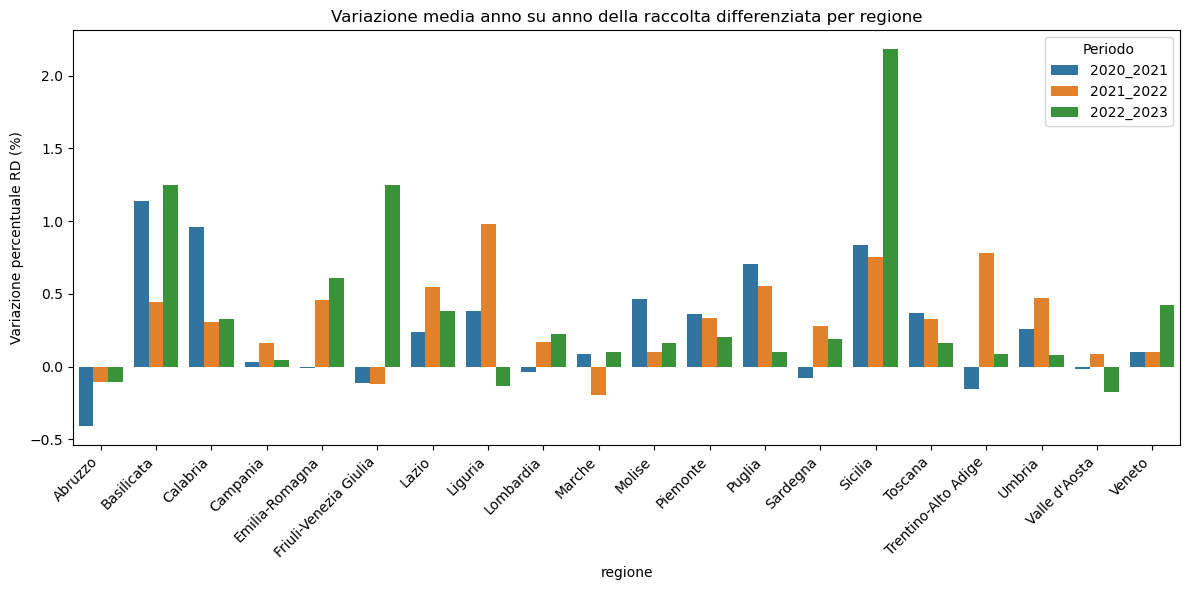

In [8]:

plt.figure(figsize=(12,6))
sns.barplot(data=df_delta_long, x="regione", y="delta_RD_perc", hue="periodo")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Variazione percentuale RD (%)")
plt.title("Variazione media anno su anno della raccolta differenziata per regione")
plt.legend(title="Periodo")
plt.tight_layout()
plt.show()

<h1> Δ rifiuti totali e pro capite anno-su-anno </h1>

In [9]:

df = pd.read_csv(
    "RU_Comunali_2020_2023_finale_aggregato_pulito.csv",
    sep=";",             # separatore corretto
    encoding="utf-8",
    on_bad_lines="skip"
)
anni = [2020, 2021, 2022, 2023]
for y in anni:
    col = f"percentuale_rd_perc_{y}"
    df[col] = df[col].astype(str).str.replace(",", ".").astype(float)
    
    
for i in range(1, len(anni)):
    y_prev = anni[i-1]
    y_curr = anni[i]
    df[f"delta_percentuale_rd_{y_prev}_{y_curr}"] = df[f"percentuale_rd_perc_{y_curr}"] - df[f"percentuale_rd_perc_{y_prev}"]

# Verifica prime righe
print(df[[f"percentuale_rd_perc_2020", f"percentuale_rd_perc_2021", f"delta_percentuale_rd_2020_2021"]].head())


   percentuale_rd_perc_2020  percentuale_rd_perc_2021  \
0                     66.64                      0.00   
1                      0.00                     62.21   
2                      0.00                      0.00   
3                      0.00                      0.00   
4                     61.69                      0.00   

   delta_percentuale_rd_2020_2021  
0                          -66.64  
1                           62.21  
2                            0.00  
3                            0.00  
4                          -61.69  


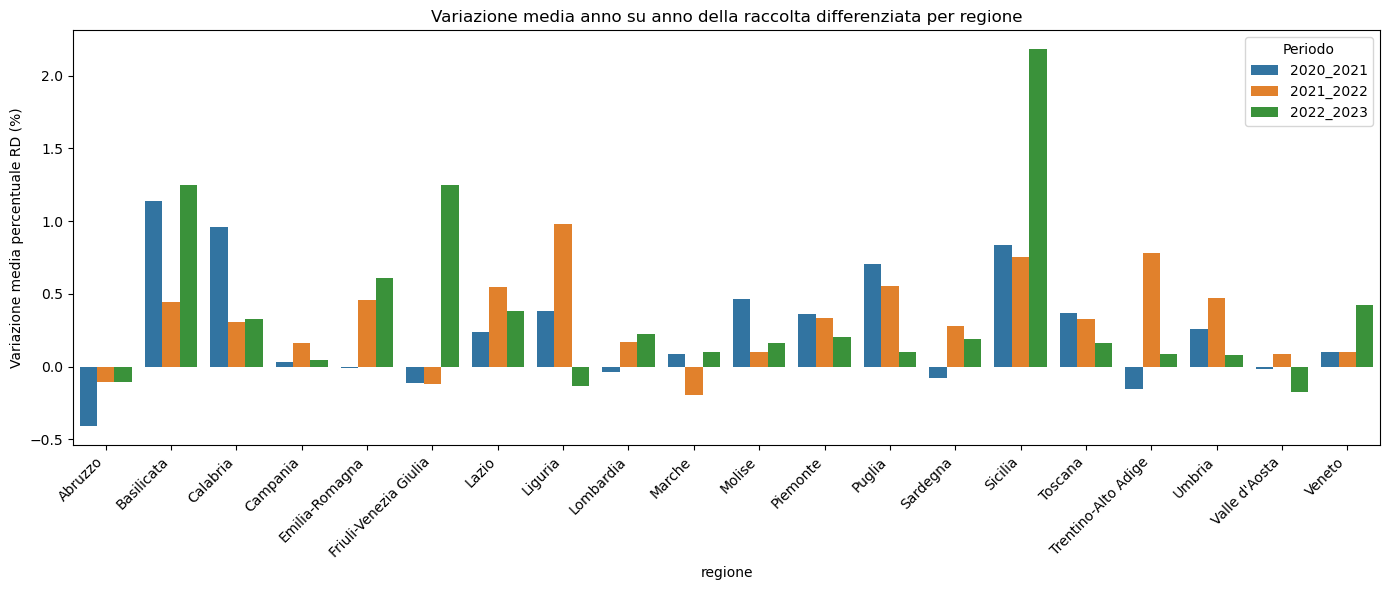

In [10]:

# Raggruppiamo per regione e calcoliamo la media dei delta
delta_cols = [f"delta_percentuale_rd_{anni[i-1]}_{anni[i]}" for i in range(1, len(anni))]
df_delta_region = df.groupby("regione")[delta_cols].mean().reset_index()

# Trasformiamo in formato long per Seaborn
df_delta_long = df_delta_region.melt(
    id_vars="regione",
    value_vars=delta_cols,
    var_name="periodo",
    value_name="delta_RD_perc"
)

# Pulizia nomi periodo
df_delta_long["periodo"] = df_delta_long["periodo"].str.replace("delta_percentuale_rd_", "")

# Grafico a barre delle variazioni medie per regione
plt.figure(figsize=(14,6))
sns.barplot(data=df_delta_long, x="regione", y="delta_RD_perc", hue="periodo")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Variazione media percentuale RD (%)")
plt.title("Variazione media anno su anno della raccolta differenziata per regione")
plt.legend(title="Periodo")
plt.tight_layout()
plt.show()

<h1> Δ complessivo 2020-2023 </h1>

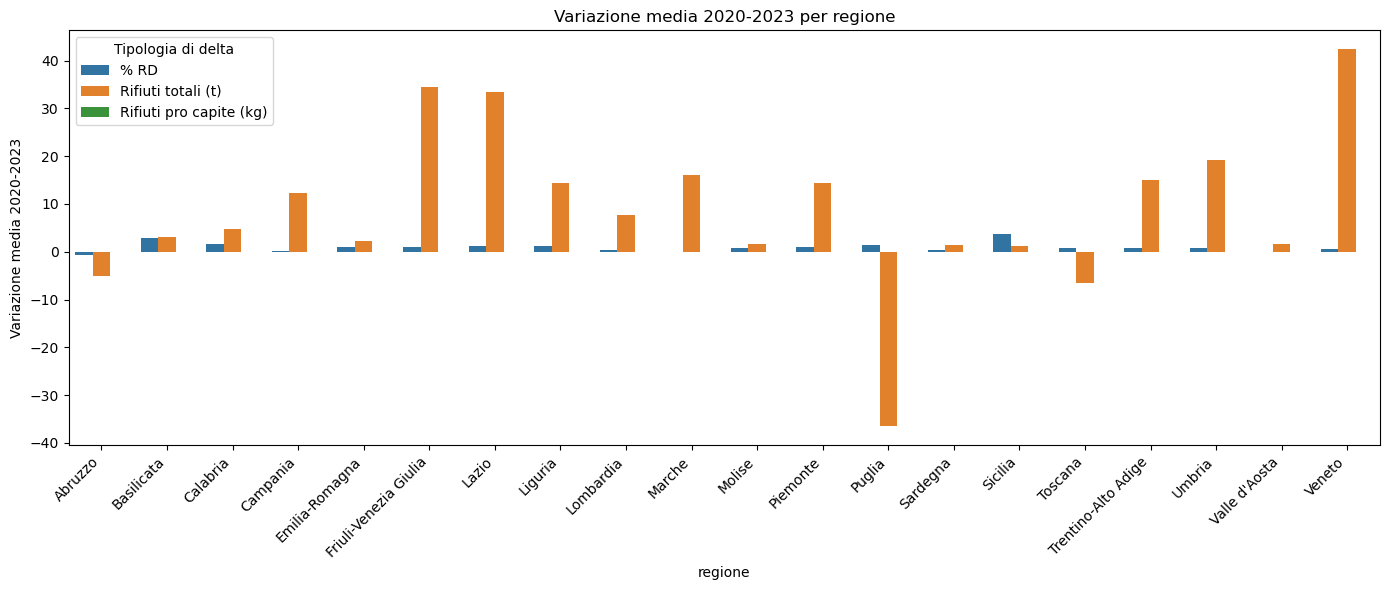

In [11]:

# Carica il CSV 
df = pd.read_csv(
    "RU_Comunali_2020_2023_finale_aggregato_pulito.csv",
    sep=";",
    encoding="utf-8",
    on_bad_lines="skip"
)

# Convertiamo le percentuali RD e i totali in float (sostituendo la virgola)
for y in [2020, 2023]:
    df[f"percentuale_rd_perc_{y}"] = df[f"percentuale_rd_perc_{y}"].astype(str).str.replace(",", ".").astype(float)
    df[f"totale_ru_t_{y}"] = df[f"totale_ru_t_{y}"].astype(str).str.replace(",", ".").astype(float)
    df["popolazione"] = df["popolazione"].astype(str).str.replace(",", ".").astype(float)
    df[f"totale_ru_pc_{y}"] = df[f"totale_ru_t_{y}"] / df["popolazione"]

# Calcolo dei delta
df["delta_percentuale_rd_2020_2023"] = df["percentuale_rd_perc_2023"] - df["percentuale_rd_perc_2020"]
df["delta_totale_ru_t_2020_2023"] = df["totale_ru_t_2023"] - df["totale_ru_t_2020"]
df["delta_totale_ru_pc_2020_2023"] = df["totale_ru_pc_2023"] - df["totale_ru_pc_2020"]

# Media per regione
df_region = df.groupby("regione")[["delta_percentuale_rd_2020_2023", 
                                   "delta_totale_ru_t_2020_2023",
                                   "delta_totale_ru_pc_2020_2023"]].mean().reset_index()

# Trasformiamo in formato long per Seaborn
df_region_long = df_region.melt(
    id_vars="regione",
    value_vars=["delta_percentuale_rd_2020_2023", "delta_totale_ru_t_2020_2023", "delta_totale_ru_pc_2020_2023"],
    var_name="tipo_delta",
    value_name="valore"
)

# Pulizia nomi delta
df_region_long["tipo_delta"] = df_region_long["tipo_delta"].replace({
    "delta_percentuale_rd_2020_2023": "% RD",
    "delta_totale_ru_t_2020_2023": "Rifiuti totali (t)",
    "delta_totale_ru_pc_2020_2023": "Rifiuti pro capite (kg)"
})

# Grafico a barre
plt.figure(figsize=(14,6))
sns.barplot(data=df_region_long, x="regione", y="valore", hue="tipo_delta")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Variazione media 2020-2023")
plt.title("Variazione media 2020-2023 per regione")
plt.legend(title="Tipologia di delta")
plt.tight_layout()
plt.show()


<h1> Aggregazione per Regione </h1>

In [12]:
# Calcolo rifiuti urbani pro capite (kg per abitante)
for y in anni:
    df[f"totale_ru_pc_{y}"] = df[f"totale_ru_t_{y}"] / df["popolazione"]

# Ora possiamo raggruppare per regione
df_region = df.groupby("regione")[[f"percentuale_rd_perc_{y}" for y in anni] + 
                                  [f"totale_ru_pc_{y}" for y in anni]].mean().reset_index()

# Calcolo variazioni anno-su-anno a livello regionale
for i in range(1, len(anni)):
    y_prev = anni[i-1]
    y_curr = anni[i]
    df_region[f"delta_percentuale_rd_{y_prev}_{y_curr}"] = df_region[f"percentuale_rd_perc_{y_curr}"] - df_region[f"percentuale_rd_perc_{y_prev}"]
    df_region[f"delta_totale_ru_pc_{y_prev}_{y_curr}"] = df_region[f"totale_ru_pc_{y_curr}"] - df_region[f"totale_ru_pc_{y_prev}"]

# Variazione complessiva 2020-2023
df_region["delta_percentuale_rd_2020_2023"] = df_region["percentuale_rd_perc_2023"] - df_region["percentuale_rd_perc_2020"]
df_region["delta_totale_ru_pc_2020_2023"] = df_region["totale_ru_pc_2023"] - df_region["totale_ru_pc_2020"]



Miglior incremento RD: Sicilia 3.767152103559871
Peggior incremento RD: Abruzzo -0.6218999151823574
Maggiore aumento RU pro capite: Friuli-Venezia Giulia 0.01021391435935147
Maggiore diminuzione RU pro capite: Valle d'Aosta -0.052030620604519406


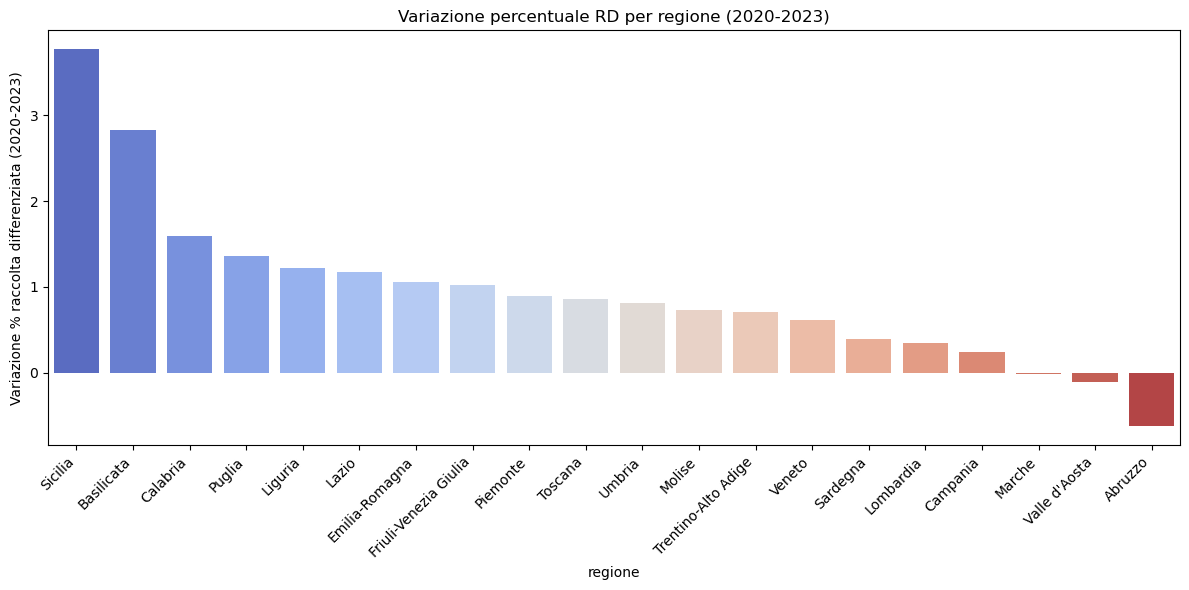

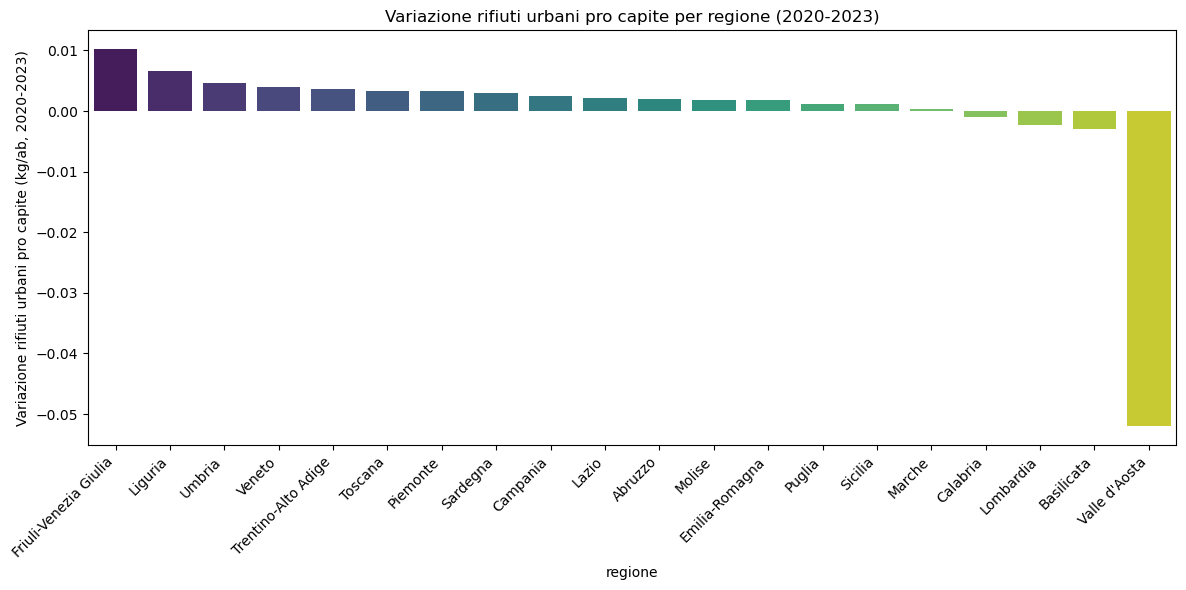

In [13]:


# Lista anni
anni = [2020, 2021, 2022, 2023]

# Calcolo rifiuti pro capite
for y in anni:
    df[f"totale_ru_pc_{y}"] = df[f"totale_ru_t_{y}"] / df["popolazione"]

# Raggruppa per regione e calcola la media
df_region = df.groupby("regione")[[f"percentuale_rd_perc_{y}" for y in anni] +
                                  [f"totale_ru_pc_{y}" for y in anni]].mean().reset_index()

# Variazioni complessive 2020-2023
df_region["delta_percentuale_rd_2020_2023"] = df_region["percentuale_rd_perc_2023"] - df_region["percentuale_rd_perc_2020"]
df_region["delta_totale_ru_pc_2020_2023"] = df_region["totale_ru_pc_2023"] - df_region["totale_ru_pc_2020"]

# Trova massimo e minimo
max_rd = df_region.loc[df_region["delta_percentuale_rd_2020_2023"].idxmax()]
min_rd = df_region.loc[df_region["delta_percentuale_rd_2020_2023"].idxmin()]

max_ru = df_region.loc[df_region["delta_totale_ru_pc_2020_2023"].idxmax()]
min_ru = df_region.loc[df_region["delta_totale_ru_pc_2020_2023"].idxmin()]

print("Miglior incremento RD:", max_rd["regione"], max_rd["delta_percentuale_rd_2020_2023"])
print("Peggior incremento RD:", min_rd["regione"], min_rd["delta_percentuale_rd_2020_2023"])
print("Maggiore aumento RU pro capite:", max_ru["regione"], max_ru["delta_totale_ru_pc_2020_2023"])
print("Maggiore diminuzione RU pro capite:", min_ru["regione"], min_ru["delta_totale_ru_pc_2020_2023"])

# Grafico a barre delle variazioni RD
plt.figure(figsize=(12,6))
sns.barplot(data=df_region.sort_values("delta_percentuale_rd_2020_2023", ascending=False),
            x="regione", y="delta_percentuale_rd_2020_2023", palette="coolwarm")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Variazione % raccolta differenziata (2020-2023)")
plt.title("Variazione percentuale RD per regione (2020-2023)")
plt.tight_layout()
plt.show()

# Grafico a barre delle variazioni RU pro capite
plt.figure(figsize=(12,6))
sns.barplot(data=df_region.sort_values("delta_totale_ru_pc_2020_2023", ascending=False),
            x="regione", y="delta_totale_ru_pc_2020_2023", palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Variazione rifiuti urbani pro capite (kg/ab, 2020-2023)")
plt.title("Variazione rifiuti urbani pro capite per regione (2020-2023)")
plt.tight_layout()
plt.show()

<h1> Grafico Δ % raccolta differenziata per regione (2020-2023) </h1>

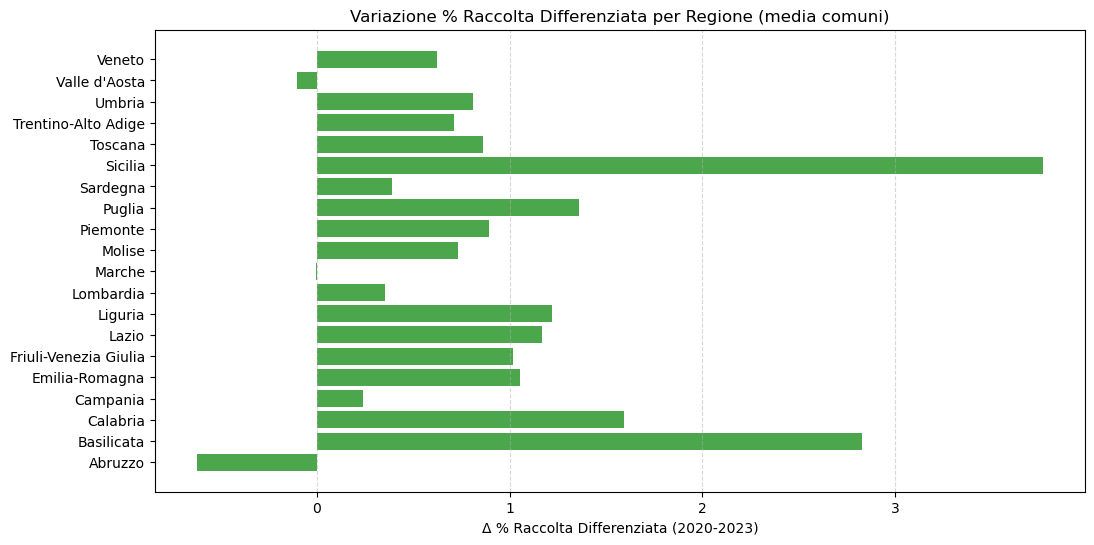

In [14]:


plt.figure(figsize=(12,6))
plt.barh(df_region["regione"], df_region["delta_percentuale_rd_2020_2023"], color='green', alpha=0.7)
plt.xlabel("Δ % Raccolta Differenziata (2020-2023)")
plt.title("Variazione % Raccolta Differenziata per Regione (media comuni)")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


<h1> Grafico Δ RU pro capite per regione (2020-2023)</h1>

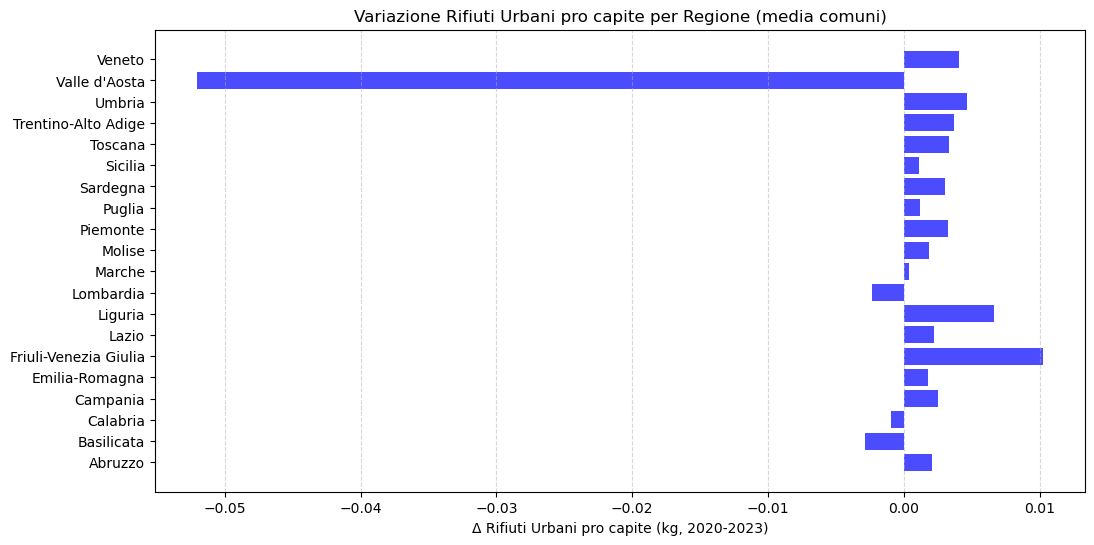

In [15]:
plt.figure(figsize=(12,6))
plt.barh(df_region["regione"], df_region["delta_totale_ru_pc_2020_2023"], color='blue', alpha=0.7)
plt.xlabel("Δ Rifiuti Urbani pro capite (kg, 2020-2023)")
plt.title("Variazione Rifiuti Urbani pro capite per Regione (media comuni)")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


<h1> Grafico combinato Δ %RD e Δ RU pro capite anno-su-anno<h1>

In [18]:

df['popolazione'] = df['popolazione'].astype(str).str.replace(".", "").str.replace(",", "").astype(float)

# Raggruppa per regione e calcola la media dei comuni
df_region = df.groupby("regione")[[f"percentuale_rd_perc_{y}" for y in anni] +
                                  [f"totale_ru_t_{y}" for y in anni] +
                                  ['popolazione']].mean().reset_index()

# Calcolo rifiuti pro capite
for y in anni:
    df_region[f"totale_ru_pc_{y}"] = df_region[f"totale_ru_t_{y}"] / df_region["popolazione"]

# Calcolo Δ anno-su-anno per %RD e RU pc
for i in range(1, len(anni)):
    y_prev = anni[i-1]
    y_curr = anni[i]
    df_region[f"delta_percentuale_rd_{y_prev}_{y_curr}"] = df_region[f"percentuale_rd_perc_{y_curr}"] - df_region[f"percentuale_rd_perc_{y_prev}"]
    df_region[f"delta_totale_ru_pc_{y_prev}_{y_curr}"] = df_region[f"totale_ru_pc_{y_curr}"] - df_region[f"totale_ru_pc_{y_prev}"]

# Δ complessivo 2020-2023
df_region["delta_percentuale_rd_2020_2023"] = df_region["percentuale_rd_perc_2023"] - df_region["percentuale_rd_perc_2020"]
df_region["delta_totale_ru_pc_2020_2023"] = df_region["totale_ru_pc_2023"] - df_region["totale_ru_pc_2020"]

df_region.head()

/var/folders/sy/499d9h4n3y33qq6nh39w03nr0000gn/T/ipykernel_33474/1212562573.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['popolazione'] = df['popolazione'].astype(str).str.replace(".", "").str.replace(",", "").astype(float)


,regione,percentuale_rd_perc_2020,percentuale_rd_perc_2021,percentuale_rd_perc_2022,percentuale_rd_perc_2023,totale_ru_t_2020,totale_ru_t_2021,totale_ru_t_2022,totale_ru_t_2023,popolazione,...,totale_ru_pc_2022,totale_ru_pc_2023,delta_percentuale_rd_2020_2021,delta_totale_ru_pc_2020_2021,delta_percentuale_rd_2021_2022,delta_totale_ru_pc_2021_2022,delta_percentuale_rd_2022_2023,delta_totale_ru_pc_2022_2023,delta_percentuale_rd_2020_2023,delta_totale_ru_pc_2020_2023
0,Abruzzo,17.976310,17.565920,17.457701,17.354411,496.222288,498.019163,489.761118,491.177730,42898.159457,...,0.011417,0.011450,-0.410390,0.000042,-0.108219,-0.000193,-0.103291,0.000033,-0.621900,-0.000118
1,Basilicata,10.813862,11.954321,12.396405,13.644512,360.835004,369.434501,366.759086,363.995987,41239.177820,...,0.008893,0.008826,1.140459,0.000209,0.442084,-0.000065,1.248107,-0.000067,2.830650,0.000077
2,Calabria,12.458785,13.417815,13.725404,14.053738,453.028123,474.962837,463.032198,457.739686,46117.388854,...,0.010040,0.009926,0.959029,0.000476,0.307589,-0.000259,0.328334,-0.000115,1.594953,0.000102
3,Campania,16.506305,16.537363,16.697547,16.745716,1178.319973,1220.810165,1202.745702,1190.524087,103079.912563,...,0.011668,0.011550,0.031058,0.000412,0.160184,-0.000175,0.048168,-0.000119,0.239411,0.000118
4,Emilia-Romagna,17.077114,17.065932,17.520975,18.129616,2183.213955,2179.139102,2151.812572,2185.514191,135652.547966,...,0.015863,0.016111,-0.011182,-0.000030,0.455042,-0.000201,0.608642,0.000248,1.052502,0.000017


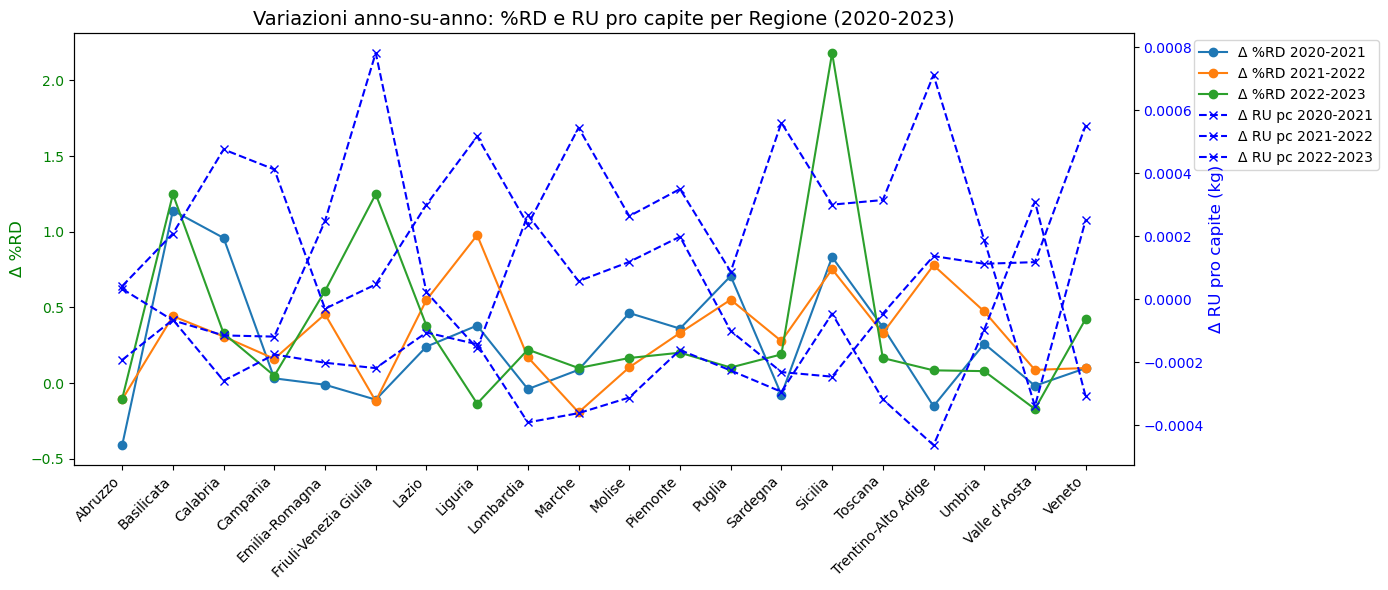

In [19]:

# Crea figura
fig, ax1 = plt.subplots(figsize=(14,6))

# Δ %RD anno-su-anno
for i in range(1, len(anni)):
    y_prev = anni[i-1]
    y_curr = anni[i]
    col_rd = f"delta_percentuale_rd_{y_prev}_{y_curr}"
    ax1.plot(df_region["regione"], df_region[col_rd], marker='o', label=f'Δ %RD {y_prev}-{y_curr}')

ax1.set_ylabel("Δ %RD", color='green', fontsize=12)
ax1.tick_params(axis='y', labelcolor='green')
plt.xticks(rotation=45, ha="right")

# Δ RU pro capite anno-su-anno
ax2 = ax1.twinx()
for i in range(1, len(anni)):
    y_prev = anni[i-1]
    y_curr = anni[i]
    col_ru = f"delta_totale_ru_pc_{y_prev}_{y_curr}"
    ax2.plot(df_region["regione"], df_region[col_ru], marker='x', linestyle='--', color='blue', label=f'Δ RU pc {y_prev}-{y_curr}')

ax2.set_ylabel("Δ RU pro capite (kg)", color='blue', fontsize=12)
ax2.tick_params(axis='y', labelcolor='blue')

# Legenda combinata
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.title("Variazioni anno-su-anno: %RD e RU pro capite per Regione (2020-2023)", fontsize=14)
plt.tight_layout()
plt.show()